In [14]:
import numpy as np
import pandas as pd
import math
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import os
from helper import *
from stats import *
from product_info import *
import helper
import stats
import dask
from dask import compute, delayed


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号


In [15]:
from imp import reload  
reload(helper)
reload(stats)

<module 'stats' from 'e:\\My_Strategies_CTA\\stats.py'>

In [16]:
HEAD_PATH = r"E:\My_Strategies_CTA" 
DATA_PATH = HEAD_PATH + "\\pkl_tick" 
NIGHT_PATH = HEAD_PATH + "\\night_pkl_tick\\"
SAVE_PATH = r"E:\My_Strategies_CTA"  #保存计算的因子数据的地方
SIGNAL_PATH = r"E:\My_Strategies_CTA" 
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [17]:
product_list = ["rb", "hc", "i", "j", "jm"]
product = product_list[0] #随便取一个商品期货，可以更改
print(product)
all_dates = os.listdir(DATA_PATH + "\\" + product)
all_dates.sort()
n_days = len(all_dates)
print(len(all_dates), all_dates[:6])

rb
1063 ['20170103.pkl', '20170104.pkl', '20170105.pkl', '20170106.pkl', '20170109.pkl', '20170110.pkl']


In [18]:
period = 4096

# train and test
train_sample = np.array(all_dates) < "2019"
test_sample = np.array(all_dates) > "2019"

# 记录时间的字符串和时间格式
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [19]:
os.makedirs(HEAD_PATH+"\\all_signals", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
n_signal = len(signal_list)

In [20]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".002"

In [21]:
coef_list=dict([])
for product in product_list:
    train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    x_train = train_mat.iloc[:, :n_signal].values
    y_train = train_mat.loc[:, y_signal].values
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train)
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
    coef = model.coef_/x_std
    print(product)
    print(coef)
    coef_list[product] = coef

rb
[-0.00000000e+00 -0.00000000e+00  1.32112153e-02 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  4.69840390e-06 -0.00000000e+00 -7.22052862e-05  0.00000000e+00
 -8.09121080e-05 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.34049707e-05
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -1.65478349e-02 -7.60806600e-03
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -6.15495611e-04
 -3.25112535e-03  6.23583901e-04 -0.00000000e+00  0.00000000e+00
  0.00000000e+00]
hc
[-0.00000000e+00 -0.00000000e+00  2.82001385e-03 -5.18453409e-03
 -0.00000000e+00  1.62402783e-04  0.00000000e+00  5.23953203e-05
 -0.00000000e+00 -0.00000000e+00 -4.88443020e-05  0.00000000e+00
  0.00000000e+00 -6.52314005e-05  0.00000000e+00  8.60695214e-04
 

In [22]:
strat = "lasso.002."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [23]:
os.makedirs(HEAD_PATH+"\\signal_mat_pkl", exist_ok=True)
for product in product_list:
    os.makedirs(HEAD_PATH+"\\signal_mat_pkl\\"+product, exist_ok=True)

In [24]:
def par_get_signal_mat(file_name, product, signal_list, HEAD_PATH, SAVE_PATH):
    data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+file_name)
    signal_mat = functools.reduce(functools.partial(get_signal_mat, product=product, file_name=file_name, HEAD_PATH=SAVE_PATH), signal_list, None)
    save(signal_mat, SAVE_PATH+"\\signal_mat_pkl\\"+product+"\\"+file_name)

In [25]:
def par_get_daily_pred(file_name, product, coef, strat, HEAD_PATH):
    signal_mat = load(HEAD_PATH+"\\signal_mat_pkl\\"+product+"\\"+file_name)
    S = np.dot(signal_mat.transpose(),coef)
    save(S, HEAD_PATH+"\\factor_pkl\\"+product+"\\"+strat+"\\"+file_name)      


In [26]:
%%time
for product in product_list:
    print(product)
    parLapply(CORE_NUM, all_dates, par_get_signal_mat, product=product, signal_list=signal_list, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

rb
hc
i
j
jm
Wall time: 13min 34s


In [27]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)

rb
hc
i
j
jm
Wall time: 2min 5s


In [28]:
def par_get_all_signal(signal_name, file_list, product, period, HEAD_PATH=HEAD_PATH):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(HEAD_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
        #data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+file)
        good = load(HEAD_PATH+"\\good_pkl\\"+product+"\\"+file)
        signal = S[good]
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, HEAD_PATH+"\\all_signals\\"+product+"."+signal_name+".pkl")

In [29]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, HEAD_PATH=SAVE_PATH)

Wall time: 22.2 s


In [32]:
split_str="2019"

In [33]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("lasso.002", np.array(all_dates), product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH, period=4096, split_str=split_str, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 4min 27s


rb train sharpe  0.3015100788618357 test sharpe  0.5863598165054786
hc train sharpe  0.9840271279996472 test sharpe  0.2495855483298399
i train sharpe  0.8615120251321614 test sharpe  -0.8212427181913234
j train sharpe  0.32948033272116684 test sharpe  0.6896787660294378
jm train sharpe  0.9451699408900707 test sharpe  1.4673043892423416
train sharpe:  1.5554285525515157 test sharpe:  0.5408961731886603


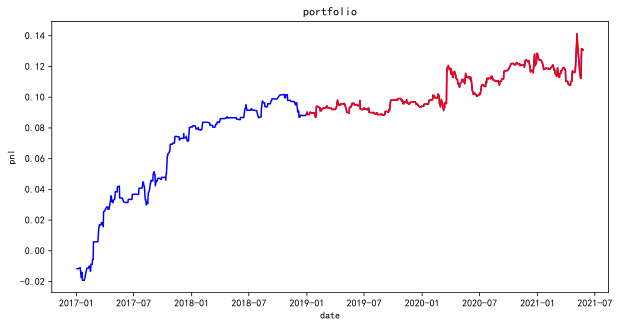

In [34]:
i = 0
strat = "lasso.002.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.title("portfolio")
plt.plot(format_dates, all_portfolio.cumsum(), color="b")
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample], color="r")
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))  

In [35]:
from sklearn.linear_model import RidgeCV
strat = "ridge.002"+str(period)

In [36]:
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [37]:
coef_list=dict([])
for product in product_list:
    train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    x_train = train_mat.iloc[:, :n_signal].values
    y_train = train_mat.loc[:, y_signal].values
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train)
    model = RidgeCV(fit_intercept=False, cv=5).fit(x_train_normal, y_train)
    coef = model.coef_/x_std
    print(product)
    print(coef)
    coef_list[product] = coef

rb
[-1.35215178e-03 -9.25469887e-04  2.50933650e-02  2.22144753e-03
 -3.78132261e-04 -6.95467376e-04  7.44276211e-02 -2.60725208e-04
  2.18596578e-04 -3.59480627e-06  3.08896077e-05  5.20739134e-04
 -2.01045932e-04  1.34725290e-04 -1.06406871e-04  1.60965960e-04
 -2.62229978e-06  1.59208827e-05  1.31695872e-03 -9.02717830e-04
 -2.31946744e-04 -5.12867323e-04 -3.71912592e-05  1.83167960e-04
  7.70713670e-03 -1.18232374e-04  5.26539759e-05 -9.81586543e-02
  3.79935581e-02 -1.13227759e-01  3.99190846e-02 -3.79344445e-02
  8.91980127e-03 -2.73655176e-01  3.92386476e-03  9.51100361e-04
  2.39467664e-02 -1.22280300e-02  1.35015663e-02 -1.65278204e-02
 -7.86794145e-03  3.55339721e-03 -2.00277133e-01 -1.37262605e-04
  3.17179306e-04]
hc
[ 8.22837792e-03  1.86730100e-03  3.78525314e-03 -1.51773986e-02
  6.51855201e-04  4.09342304e-04  4.39901617e-02  1.43936330e-03
 -1.14130137e-03 -2.43265715e-04 -5.00112424e-04 -2.52064457e-04
  8.45436889e-04 -1.64683381e-04 -5.59653899e-06  4.45245358e-03
 

In [38]:
strat = "ridge.002."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [39]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)

rb
hc
i
j
jm
Wall time: 2min 10s


In [40]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, HEAD_PATH=SAVE_PATH)

Wall time: 22.4 s


In [41]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("ridge.002", np.array(all_dates), product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH, period=4096, split_str=split_str, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 5min 7s


rb train sharpe  nan test sharpe  nan
hc train sharpe  1.1090526215217564 test sharpe  0.991592519082524
i train sharpe  0.443386119181694 test sharpe  -0.573832620720769
j train sharpe  0.5135091251727041 test sharpe  -1.0129944365029409
jm train sharpe  nan test sharpe  nan
train sharpe:  nan test sharpe:  nan


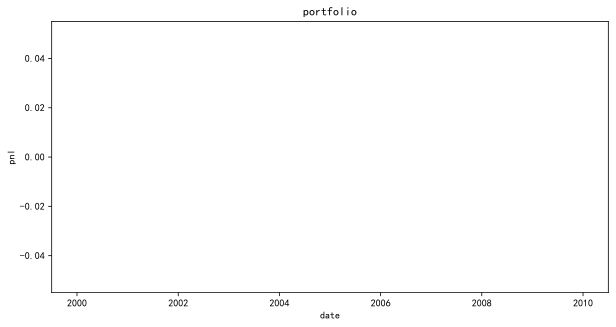

In [42]:
i = 0
strat = "ridge.002.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.title("portfolio")
plt.plot(format_dates, all_portfolio.cumsum(), color="b")
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample], color="r")
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))  

In [43]:
from sklearn.linear_model import ElasticNetCV
strat = "elastic.002."+str(period)

In [44]:
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [45]:
coef_list=dict([])
for product in product_list:
    train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    x_train = train_mat.iloc[:, :n_signal].values
    y_train = train_mat.loc[:, y_signal].values
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train)
    model = ElasticNetCV(n_alphas=100, l1_ratio=0.5, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
    coef = model.coef_/x_std
    print(product)
    print(coef)
    coef_list[product] = coef

rb
[-0.00000000e+00 -0.00000000e+00  1.32095242e-02 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  4.64649176e-06 -0.00000000e+00 -7.21537651e-05  0.00000000e+00
 -8.08976176e-05 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.35655604e-05
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -1.65484122e-02 -7.60793758e-03
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -6.15747898e-04
 -3.25018414e-03  6.23433890e-04 -0.00000000e+00  0.00000000e+00
  0.00000000e+00]
hc
[-0.00000000e+00 -0.00000000e+00  2.82008817e-03 -5.18417920e-03
 -0.00000000e+00  1.62391583e-04  0.00000000e+00  5.23665551e-05
 -0.00000000e+00 -0.00000000e+00 -4.88401539e-05  0.00000000e+00
  0.00000000e+00 -6.52113068e-05  0.00000000e+00  8.60427504e-04
 

In [46]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)

rb
hc
i
j
jm
Wall time: 2min 7s


In [47]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, HEAD_PATH=SAVE_PATH)

Wall time: 21.3 s


In [48]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("elastic.002", np.array(all_dates), product, 2, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH, period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread*1.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 4min 45s


rb train sharpe  0.3002640495788593 test sharpe  0.5934722364467039
hc train sharpe  0.9838873198259507 test sharpe  0.23871922442456417
i train sharpe  0.8615120251321614 test sharpe  -0.822755848461863
j train sharpe  0.33073731197795087 test sharpe  0.6894150302293027
jm train sharpe  0.9451699408900707 test sharpe  1.4673043892423416
train sharpe:  1.555338267496114 test sharpe:  0.5384875962081396


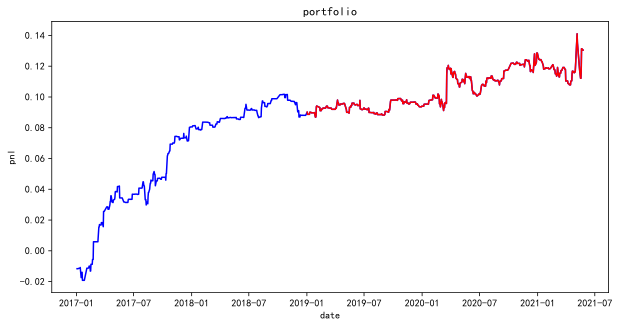

In [49]:
i = 0
strat = "elastic.002.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.title("portfolio")
plt.plot(format_dates, all_portfolio.cumsum(), color="b")
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample], color="r")
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))  

In [51]:
os.makedirs(HEAD_PATH + "\\coefficients", exist_ok=True)
for product in product_list:
    file_name = HEAD_PATH + "\\coefficients\\"+product+".signal.txt"
    fo = open(file_name, "w")
    fo.writelines("signal coef\n")
    chosen_signal = coef_list[product]!=0
    for i in np.where(chosen_signal)[0]:
        fo.writelines(signal_list[i]+" "+str(coef_list[product][i])+"\n")
    fo.close()

In [56]:
coef_list

{'rb': array([-0.00000000e+00, -0.00000000e+00,  1.32095242e-02, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         4.64649176e-06, -0.00000000e+00, -7.21537651e-05,  0.00000000e+00,
        -8.08976176e-05, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -1.35655604e-05,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -1.65484122e-02, -7.60793758e-03,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -6.15747898e-04,
        -3.25018414e-03,  6.23433890e-04, -0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]),
 'hc': array([-0.00000000e+00, -0.00000000e+00,  2.82008817e-03, -5.18417920e-03,
        -0.00000000e+00,  1.62391583e-04,  0.0000

In [61]:
# confirm with the signals chosen in the regularized model for each commodity
for product in product_list:
    chosen_signal = coef_list[product]!=0
    print(chosen_signal)

[False False  True False False False False False  True False  True False
  True False False False False False False  True False False False False
 False False False False False False  True  True False False False False
 False False False  True  True  True False False False]
[False False  True  True False  True False  True False False  True False
 False  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False]
[ True  True False False False  True False False False False False  True
 False False False False  True False False  True False  True False False
 False False False False False False False False False  True False  True
  True False  True  True  True  True False  True False]
[False False False  True False  True False False False  True False False
 False False False False False False  True False False False False False
 False False False False Fals

In [57]:
for product in product_list:
    print(coef_list[product])

[-0.00000000e+00 -0.00000000e+00  1.32095242e-02 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  4.64649176e-06 -0.00000000e+00 -7.21537651e-05  0.00000000e+00
 -8.08976176e-05 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.35655604e-05
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -1.65484122e-02 -7.60793758e-03
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -6.15747898e-04
 -3.25018414e-03  6.23433890e-04 -0.00000000e+00  0.00000000e+00
  0.00000000e+00]
[-0.00000000e+00 -0.00000000e+00  2.82008817e-03 -5.18417920e-03
 -0.00000000e+00  1.62391583e-04  0.00000000e+00  5.23665551e-05
 -0.00000000e+00 -0.00000000e+00 -4.88401539e-05  0.00000000e+00
  0.00000000e+00 -6.52113068e-05  0.00000000e+00  8.60427504e-04
  0.000